# Genesis4 Basic Example

This will show the basic usage of LUME-Genesis.

In [1]:
from genesis.version4 import Genesis4

## Setup

Instantiate the object on a value init file. This will configure a working directory that stages all input and output files.

In [2]:
FILE = 'data/basic4/cu_hxr.in'

G = Genesis4(FILE, verbose = True)

Configured to run in: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmplx0omeuu


Input is simply a list of dicts corresponding to the namelist

In [3]:
G.input

{'main': [{'type': 'setup',
   'rootname': 'LCLS2_HXR_9keV',
   'lattice': '/Users/cmayes/Code/GitHub/lume-genesis/docs/examples/genesis4/data/basic4/hxr.lat',
   'beamline': 'HXR',
   'lambda0': 1.3789244869952112e-10,
   'gamma0': 19174.0776,
   'delz': 0.026,
   'seed': 84672,
   'npart': 1024},
  {'type': 'time', 'slen': 1.5e-05, 'sample': 200},
  {'type': 'field', 'dgrid': 0.0001, 'ngrid': 101, 'accumulate': True},
  {'type': 'profile_file',
   'label': 'beamcurrent',
   'xdata': array([0.00000000e+00, 7.50037502e-10, 1.50007500e-09, ...,
          1.49984999e-05, 1.49992500e-05, 1.50000000e-05]),
   'ydata': array([2.65147892, 2.65521019, 2.65894633, ..., 2.65894633, 2.65521019,
          2.65147892])},
  {'type': 'profile_file',
   'label': 'beamgamma',
   'xdata': array([0.00000000e+00, 7.50037502e-10, 1.50007500e-09, ...,
          1.49984999e-05, 1.49992500e-05, 1.50000000e-05]),
   'ydata': array([19394.23415577, 19394.21213902, 19394.19012226, ...,
          18953.96507774,

Change something

In [4]:
G.input['main'][6]['zstop'] = 92

In [5]:
# Add writing a field file
G.input['main'].append({'type':'write', 'field':'end'})

# Add writing a beam (particle) file
G.input['main'].append({'type':'write', 'beam':'end'})

## Run
Run with MPI. Here, setting `G.nproc = 0` will automatically select the maximum number of CPUs.

In [6]:
G.nproc = None
G.run()

Setting use_mpi = True because nproc = 0
Running Genesis4 in /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmplx0omeuu
/opt/local/bin/mpirun -n 0 /Users/cmayes/miniconda3/envs/genesis-dev/bin/genesis4 genesis4.in
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Thu Jan  4 11:32:36 2024

MPI-Comm Size: 10 nodes

Parsing lattice file...
Setting up time window of 15.1682 microns with 550 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 550 slices for a time window of 15.1682 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculation: 10% done
  Calculation: 20% done
  Calculation: 30% done
  Calculation: 40% done
  Calculation:

--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  ChristohersMBP2
  System call: unlink(2) /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T//ompi.ChristohersMBP2.501/pid.32526/1/vader_segment.ChristohersMBP2.501.1c130001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


Calculation terminated due to requested stop.
Writing output file...



Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing field distribution to file: end.fld.h5 ...
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Time: Thu Jan  4 07:18:56 2024
Total Wall Clock Time: 223.082 seconds
-------------------------------------


Finished.
Loading main output: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmpjlcq3y1h/LCLS2_HXR_9keV.out.h5


## Output

The main output is an HDF5. The Genesis4 object loads this data into a flat dict

In [7]:
G.output.keys()

dict_keys(['run_info', 'outfile', 'Beam/LSCfield', 'Beam/alphax', 'Beam/alphay', 'Beam/betax', 'Beam/betay', 'Beam/bunching', 'Beam/bunchingphase', 'Beam/current', 'Beam/efield', 'Beam/emax', 'Beam/emin', 'Beam/emitx', 'Beam/emity', 'Beam/energy', 'Beam/energyspread', 'Beam/pxmax', 'Beam/pxmin', 'Beam/pxposition', 'Beam/pymax', 'Beam/pymin', 'Beam/pyposition', 'Beam/wakefield', 'Beam/xmax', 'Beam/xmin', 'Beam/xposition', 'Beam/xsize', 'Beam/ymax', 'Beam/ymin', 'Beam/yposition', 'Beam/ysize', 'Field/dgrid', 'Field/intensity-farfield', 'Field/intensity-nearfield', 'Field/ngrid', 'Field/phase-farfield', 'Field/phase-nearfield', 'Field/power', 'Field/xdivergence', 'Field/xpointing', 'Field/xposition', 'Field/xsize', 'Field/ydivergence', 'Field/ypointing', 'Field/yposition', 'Field/ysize', 'Global/frequency', 'Global/gamma0', 'Global/lambdaref', 'Global/one4one', 'Global/s', 'Global/sample', 'Global/scan', 'Global/slen', 'Global/time', 'Lattice/aw', 'Lattice/ax', 'Lattice/ay', 'Lattice/chic

This is the output file that was loaded

In [8]:
G.output['outfile']

'/var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmplx0omeuu/LCLS2_HXR_9keV.out.h5'

In [9]:
G.expand_alias('sigma_x')

'sigma_x'

There are many outputs. `.output_info()` gives a convenient table describing what was read in.

In [10]:
G.output_info()

Output data

key                       value              unit
--------------------------------------------------
Beam/LSCfield             array: (2544, 550)  eV/m
Beam/alphax               array: (1, 550)    rad
Beam/alphay               array: (1, 550)    rad
Beam/betax                array: (1, 550)    m
Beam/betay                array: (1, 550)    m
Beam/bunching             array: (2544, 550)  
Beam/bunchingphase        array: (2544, 550)  rad
Beam/current              array: (2544, 550)  A
Beam/efield               array: (2544, 550)  eV/m
Beam/emax                 array: (2544, 550)  m_ec^2
Beam/emin                 array: (2544, 550)  m_ec^2
Beam/emitx                array: (1, 550)    m
Beam/emity                array: (1, 550)    m
Beam/energy               array: (2544, 550)  m_ec^2
Beam/energyspread         array: (2544, 550)  m_ec^2
Beam/pxmax                array: (2544, 550)  rad
Beam/pxmin                array: (2544, 550)  rad
Beam/pxposition           array: (2544, 5

## Fields

Field files can be very large and are not loaded by default. Instead, the files found are collected as a list:

In [11]:
G.output['field_files']

['/var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmplx0omeuu/end.fld.h5']

This will load all files in the list

In [12]:
G.load_fields()

Loaded field data: end


In [13]:
G.output['field'].keys()

dict_keys(['end'])

This field data has two parts: basic parameters `param`, and the raw 3D complex array `dfl`:

In [14]:
G.output['field']['end']['param']

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 550,
 'slicespacing': 2.7578489739904225e-08}

In [15]:
G.output['field']['end']['dfl'].shape

(101, 101, 550)

`.field` is a convenience property that points to this

In [16]:
G.field.keys()

dict_keys(['end'])

## Visualize Field

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [18]:
# Sum over y and compute the absolute square 
dfl = G.field['end']['dfl']
param = G.field['end']['param']
dat2 = np.abs(np.sum(dfl, axis=1))**2

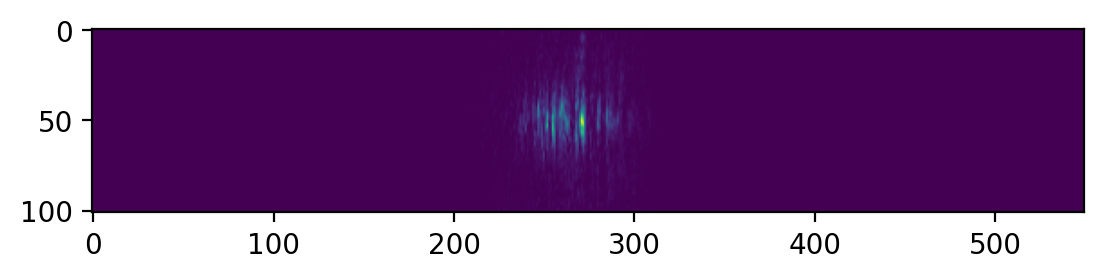

In [19]:
plt.imshow(dat2)

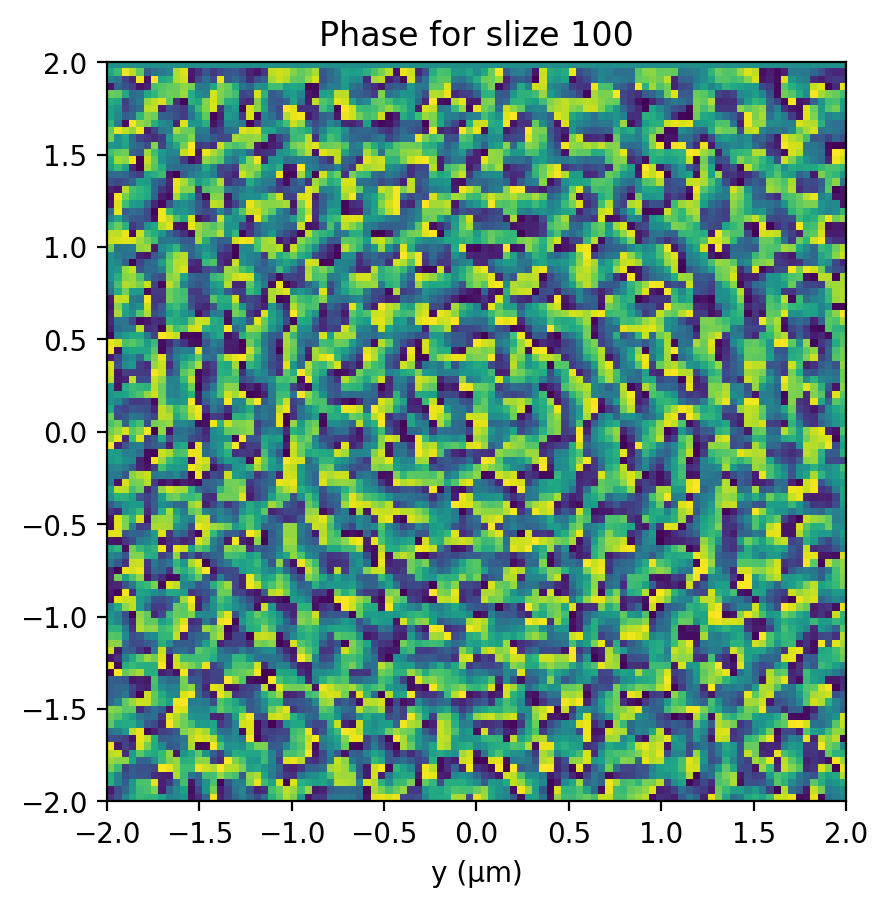

In [20]:
def plot_slice(i=0):
    
    dat = np.angle(dfl[:,:,i])
    
    dx = param['gridsize']*1e6
    plt.xlabel('x (µm)')
    plt.xlabel('y (µm)')
    plt.title(f'Phase for slize {i}')
    plt.imshow(dat.T, origin='lower', extent=[-dx,dx,-dx,dx])
plot_slice(i=100)

# Particles

Particle files can be read in as [openPMD-beamphysics](https://christophermayes.github.io/openPMD-beamphysics/) `ParticleGroup` objects.

In [21]:
G.output['particle_files']

['/var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmplx0omeuu/end.par.h5']

In [22]:
G.load_particles()

Loaded particle data: 'end' as a ParticleGroup with 563200 particles


In [23]:
G.output['particles']

{'end': <ParticleGroup with 563200 particles at 0x12c701b20>}

In [24]:
P = G.output['particles']['end']

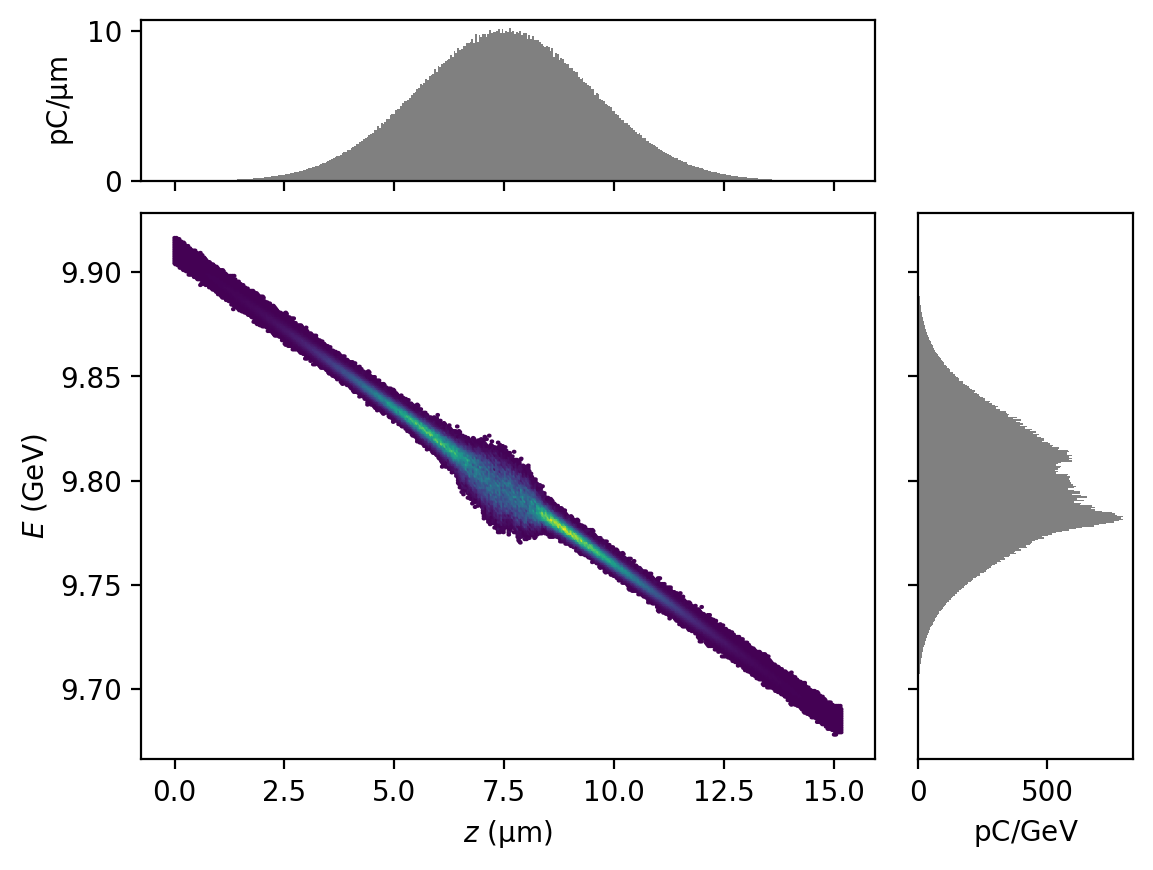

In [25]:
P.plot('z', 'energy')

Change to z coordinates to see the current. Note that the head of the bunch is now on the left.

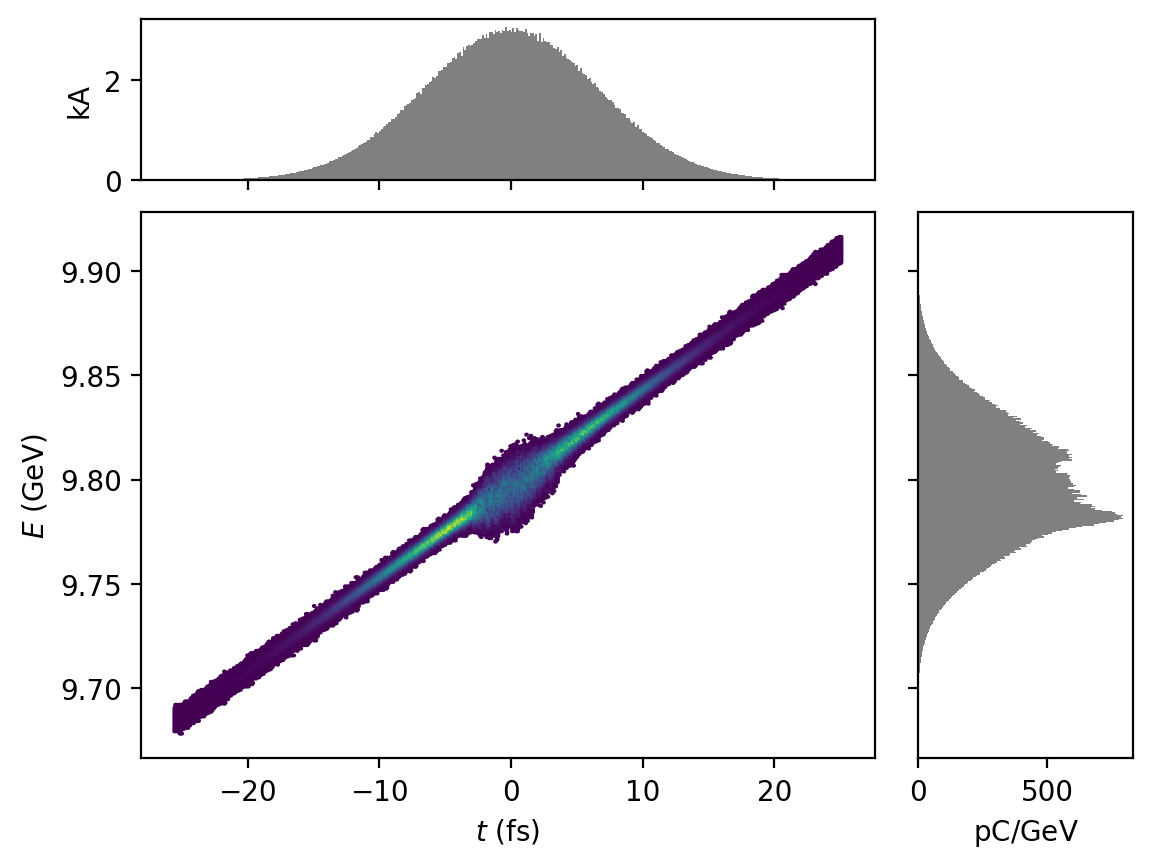

In [26]:
P.drift_to_z()
P.plot('t', 'energy')

Check some statistics

In [27]:
P['norm_emit_x'], P['norm_emit_y'], P['mean_gamma']

(4.0001127323766824e-07, 4.00034230335603e-07, 19172.359543691495)

## Bunching

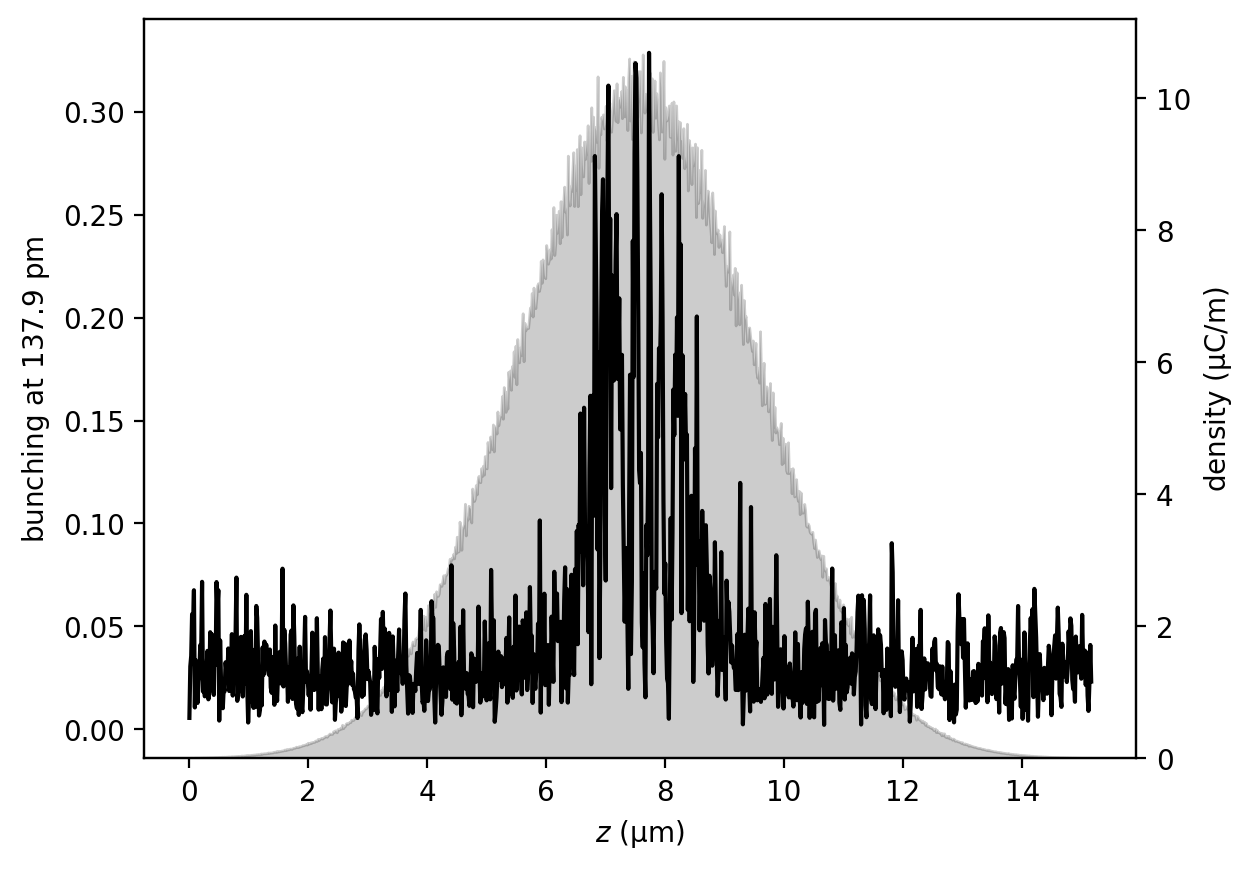

In [28]:
wavelength = G.input['main'][0]['lambda0']
bunching_key = f'bunching_{wavelength}'
P.drift_to_t()

P.slice_plot(bunching_key, n_slice=1000)

In [29]:
# Genesis4 data
final_bunching = G.output['Beam/bunching'][-1,:]
current = G.output['Beam/current'][-1,:]
s = G.output['Global/s']


# ParticleGroup data
ss = P.slice_statistics(bunching_key, n_slice=len(s))
ss.keys()
x = ss['mean_z']
y = ss[bunching_key]


Compare 

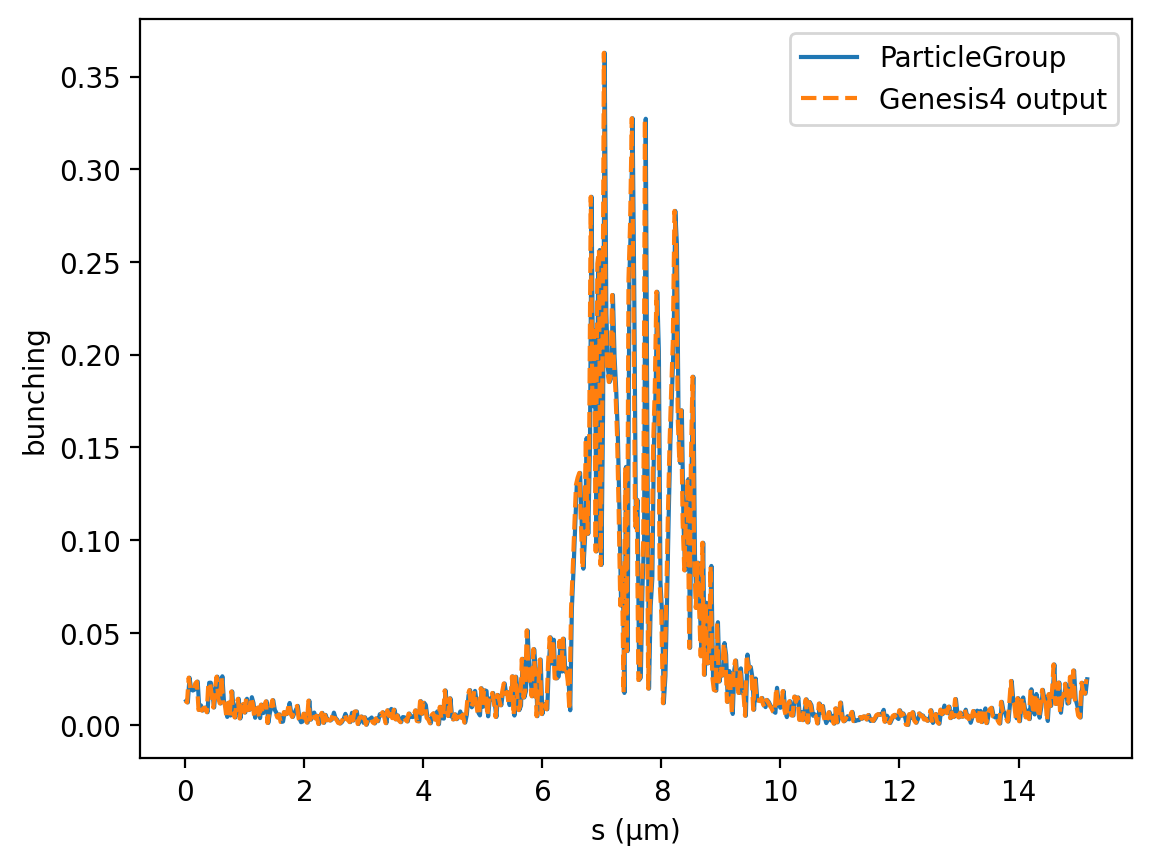

In [30]:
fig, ax = plt.subplots()
ax.plot(x*1e6, y, label='ParticleGroup')
ax.plot(s*1e6, final_bunching, '--', label='Genesis4 output')
ax.set_xlabel('s (µm)')
ax.set_ylabel('bunching')
plt.legend()

This is the average bunching from the ParticleGroup:

In [31]:
P.bunching(wavelength)

(0.004322585534920312+0.011704956812382527j)

That agrees with the appropriate averaging of Genesis4's bunching calc:

In [32]:
G.stat('bunching')[-1]

0.012477610335575666

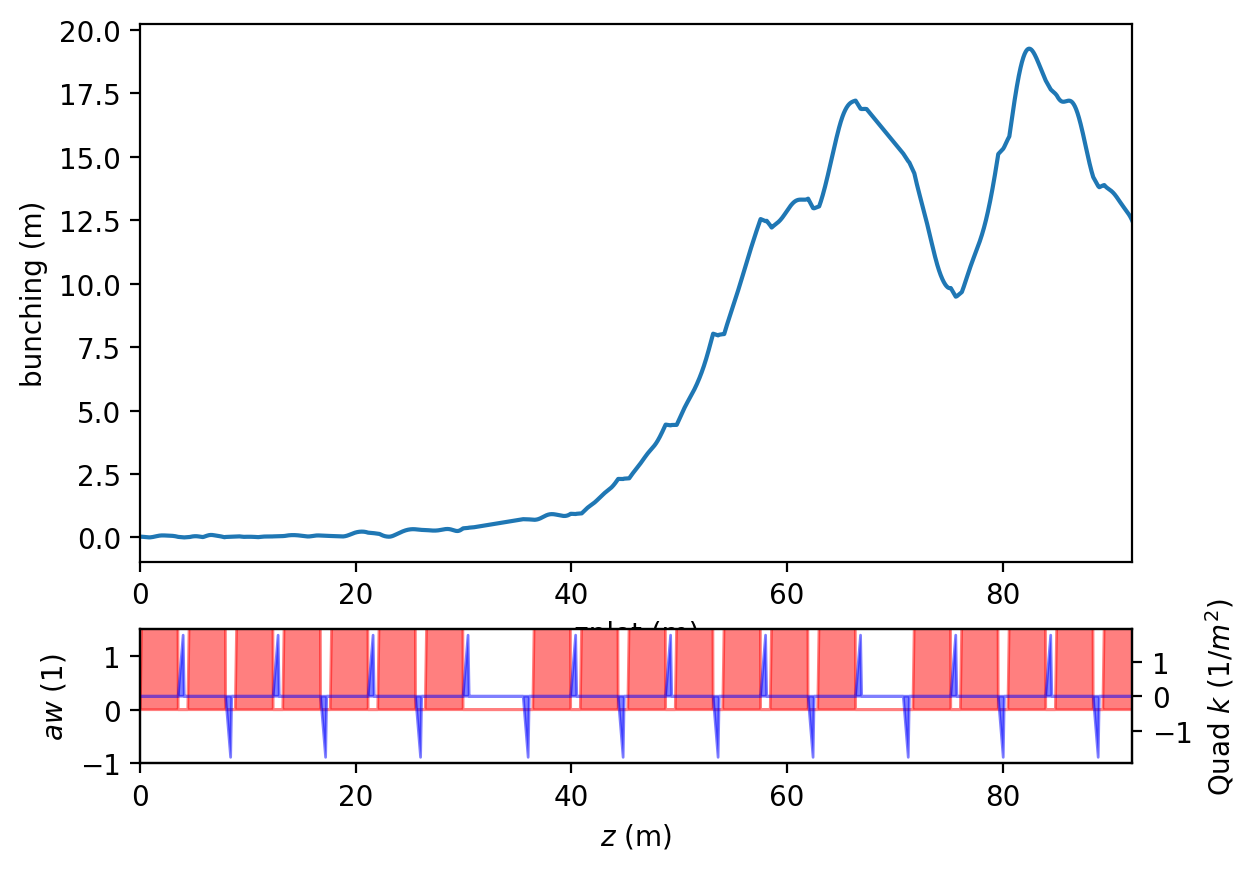

In [33]:
G.plot('bunching')

Check the total charge in pC:

In [34]:
P['charge'] / 1e-12 # pC

50.15988604937902

## Units

Each item in the output dict has a corresponding units

In [35]:
G.units('Beam/betax')

pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0))

# Plotting

Convenient plotting of the data in `.output` is provided by `.plot`. The default is to plot the power. Depending on the key these statistics are averaged or integrated over the slices. Some keys like `power` are converted to `peak_power`, while `field_energy` is the integral over `field_power`. 

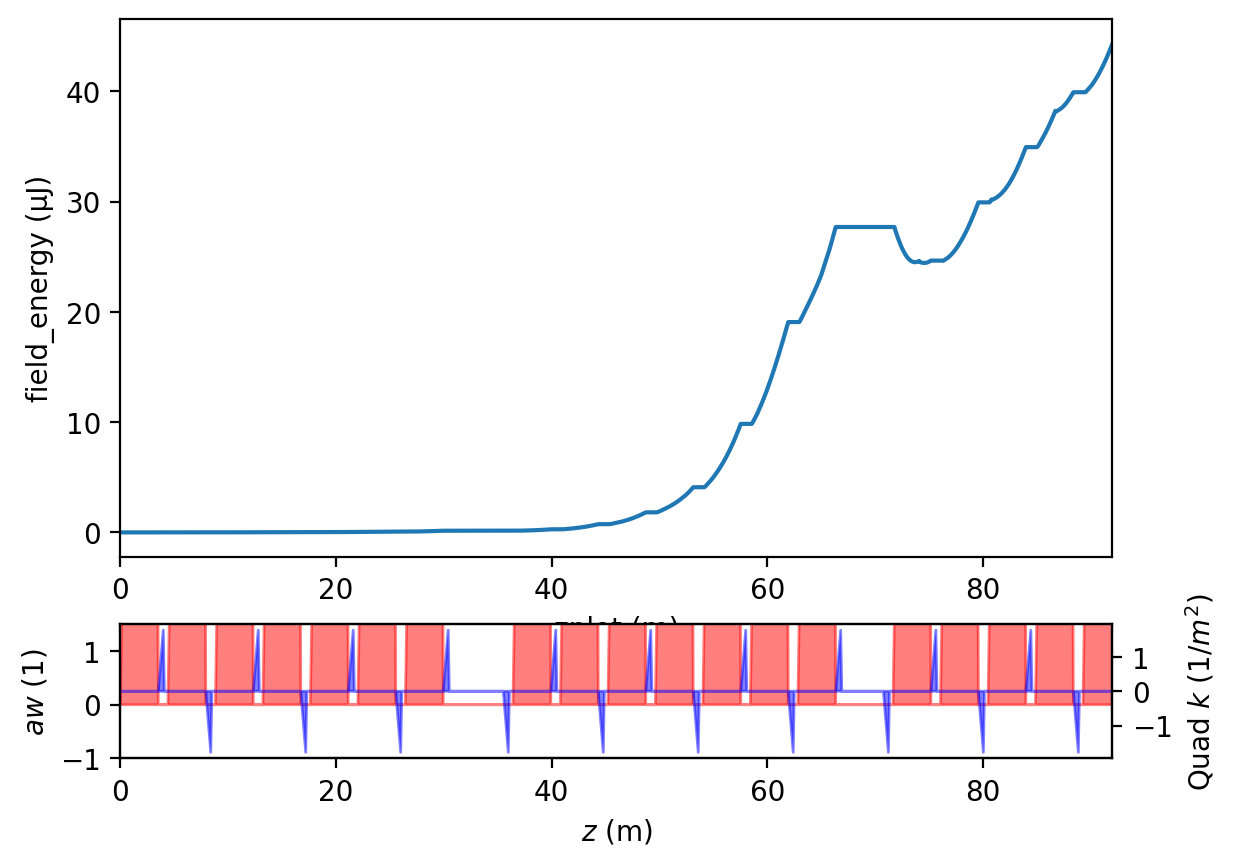

In [36]:
G.plot()

Left and right axes can be set this way:

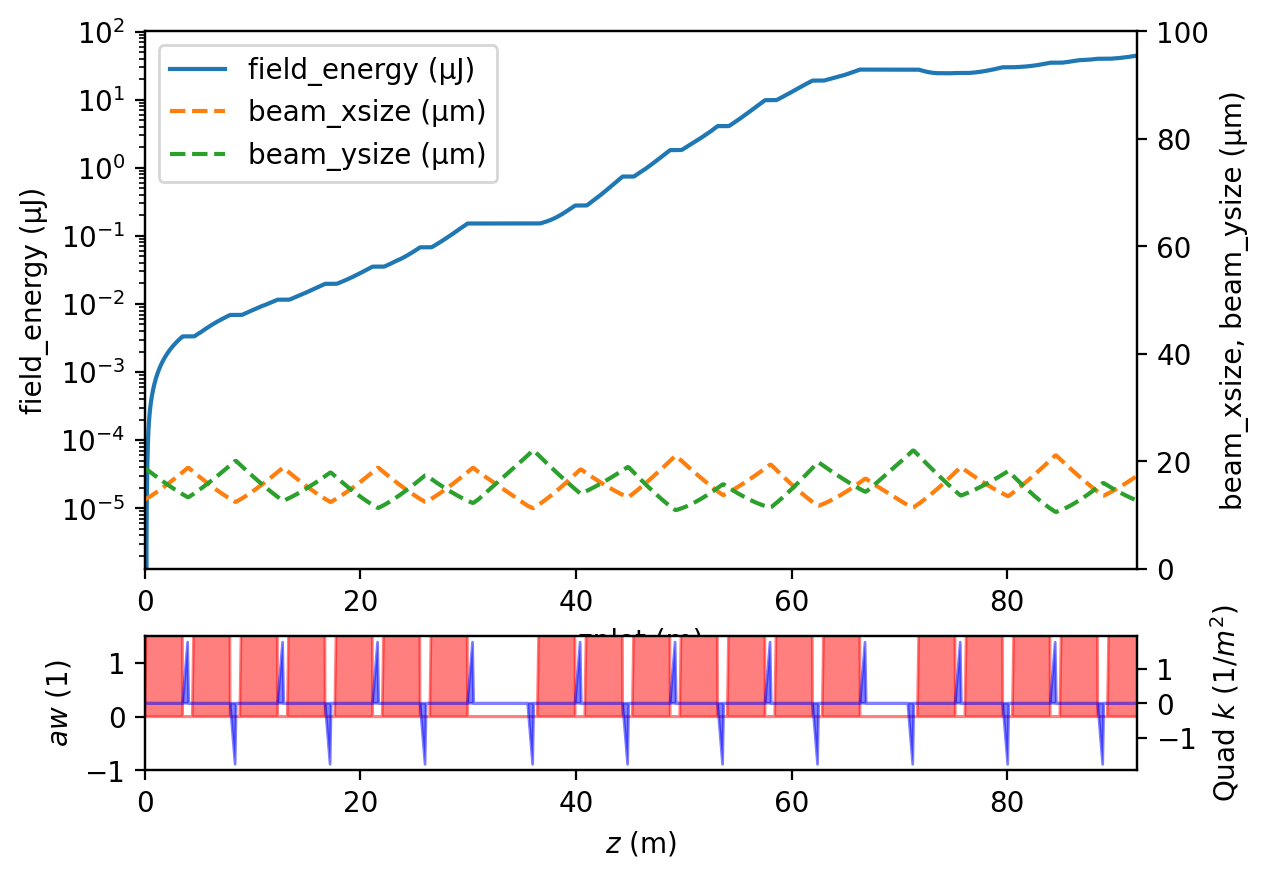

In [37]:
G.plot('field_energy', yscale='log', y2 = ['beam_xsize', 'beam_ysize'], ylim2=(0, 100e-6))

By default, these plots average over slices. In the case of beam sizes, simply averaging these does not take into account the effect of misaligned slices. To plot this, LUME-Genesis provides additional `beam_sigma_x`, `beam_sima_y`, `beam_sigma_energy` keys that properly project these quantities. The difference is noticable in the energy spread calculation:

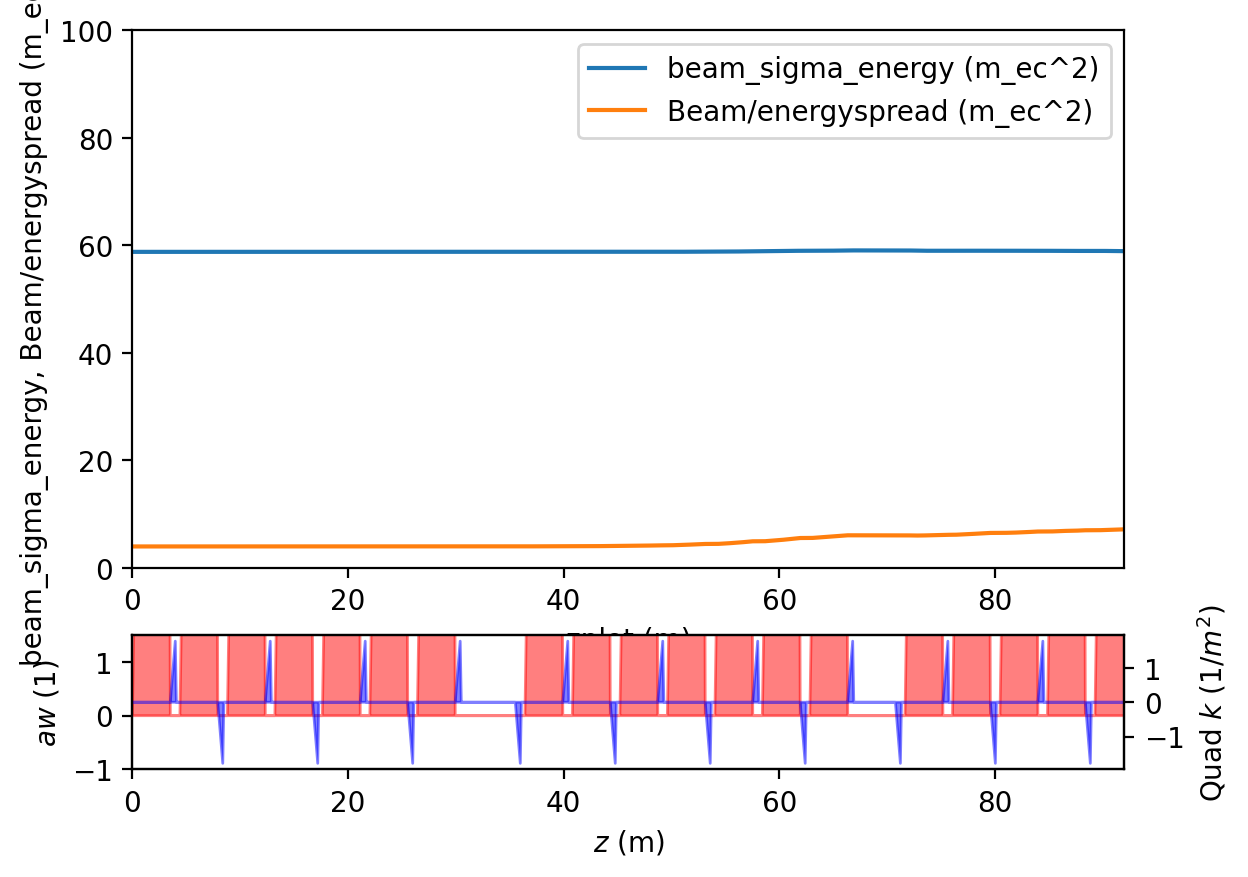

In [38]:
G.plot(['beam_sigma_energy', 'Beam/energyspread'], ylim=(0, 100))

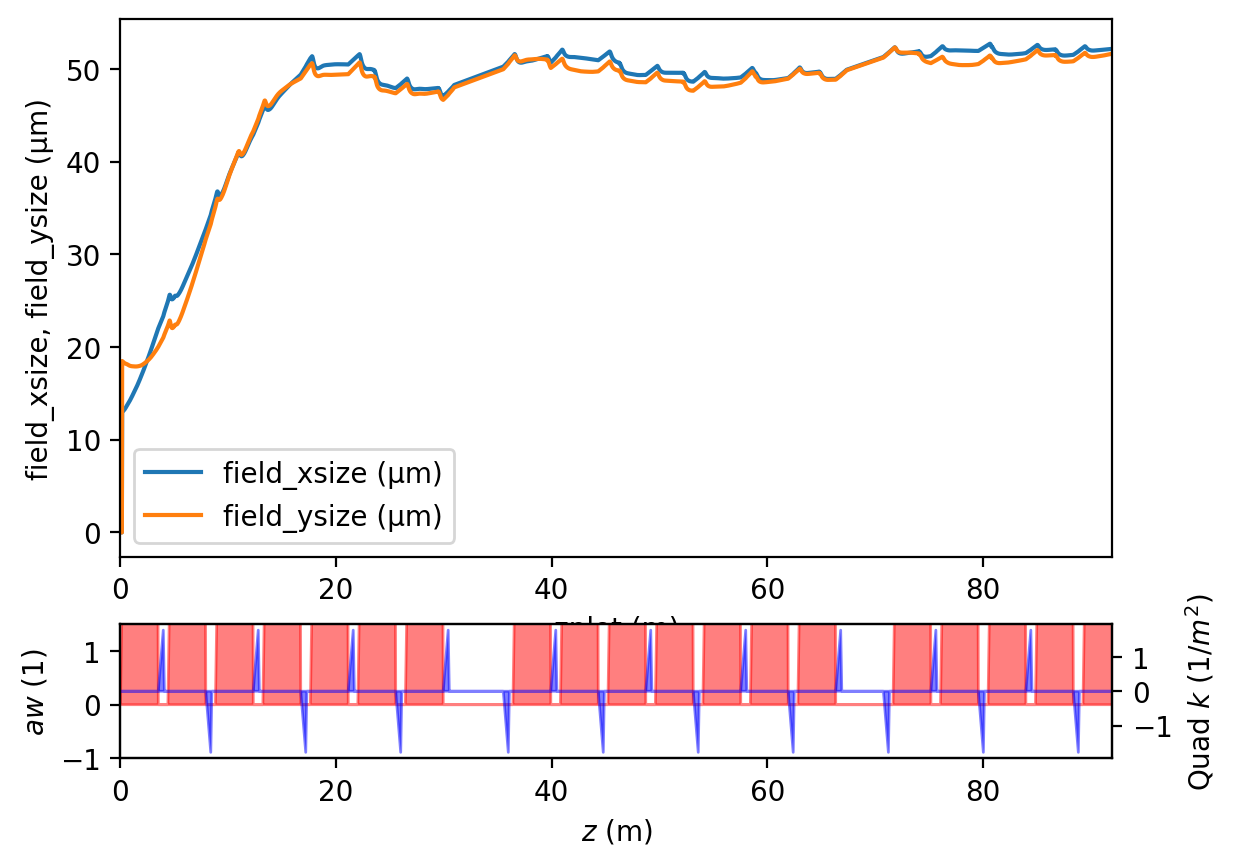

In [39]:
G.plot(['field_xsize', 'field_ysize'])

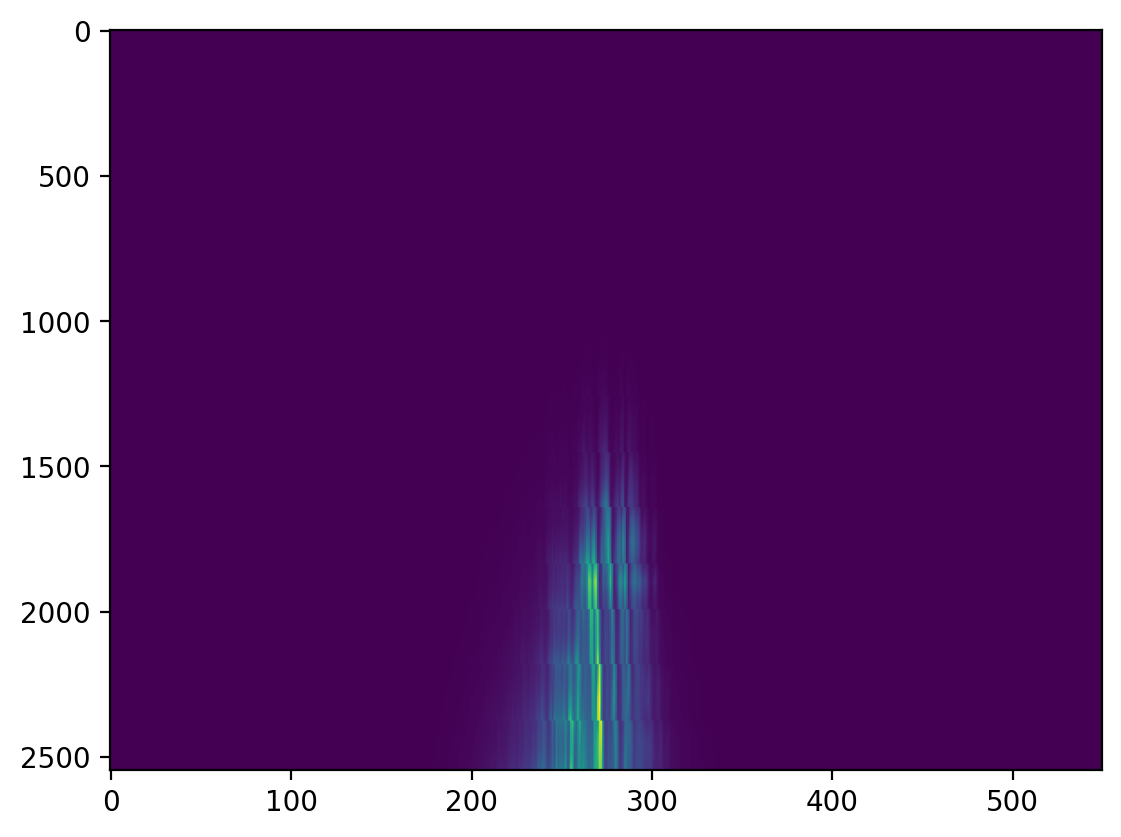

In [40]:
plt.imshow(G.output['Field/power'], aspect='auto')

## Archiving

In [41]:
afile = G.archive()

Archiving to file genesis4_625b2506a72c3620b17c1e89a5a3937a.h5


In [42]:
# This is not yet implemented
try:
    G.from_archive(afile)
except NotImplementedError:
    print('from_archive is not implemented')

from_archive is not implemented


In [43]:
G.load_output()

Loading main output: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmplx0omeuu/LCLS2_HXR_9keV.out.h5


# Manual loading of Genesis4 data

Sometimes it is necessary to run Genesis4 manually, and load the output into LUME-Genesis for further analysis.

First, let's create some input to run in a local directory `temp/`:

In [44]:
import os
os.makedirs('temp/', exist_ok=True)
G.write_input('temp/')

Now run on the command line:

In [45]:
!cd temp;./run >log.txt

Using the `use_temp_dir=False` and `workdir` options, the input and output data can be loaded into a new Genesis4 object:

In [46]:
G2 = Genesis4('temp/genesis4.in', use_temp_dir = False, workdir = 'temp/', verbose=True)
G2.load_output()

Configured to run in: temp/
Loading main output: temp/LCLS2_HXR_9keV.out.h5


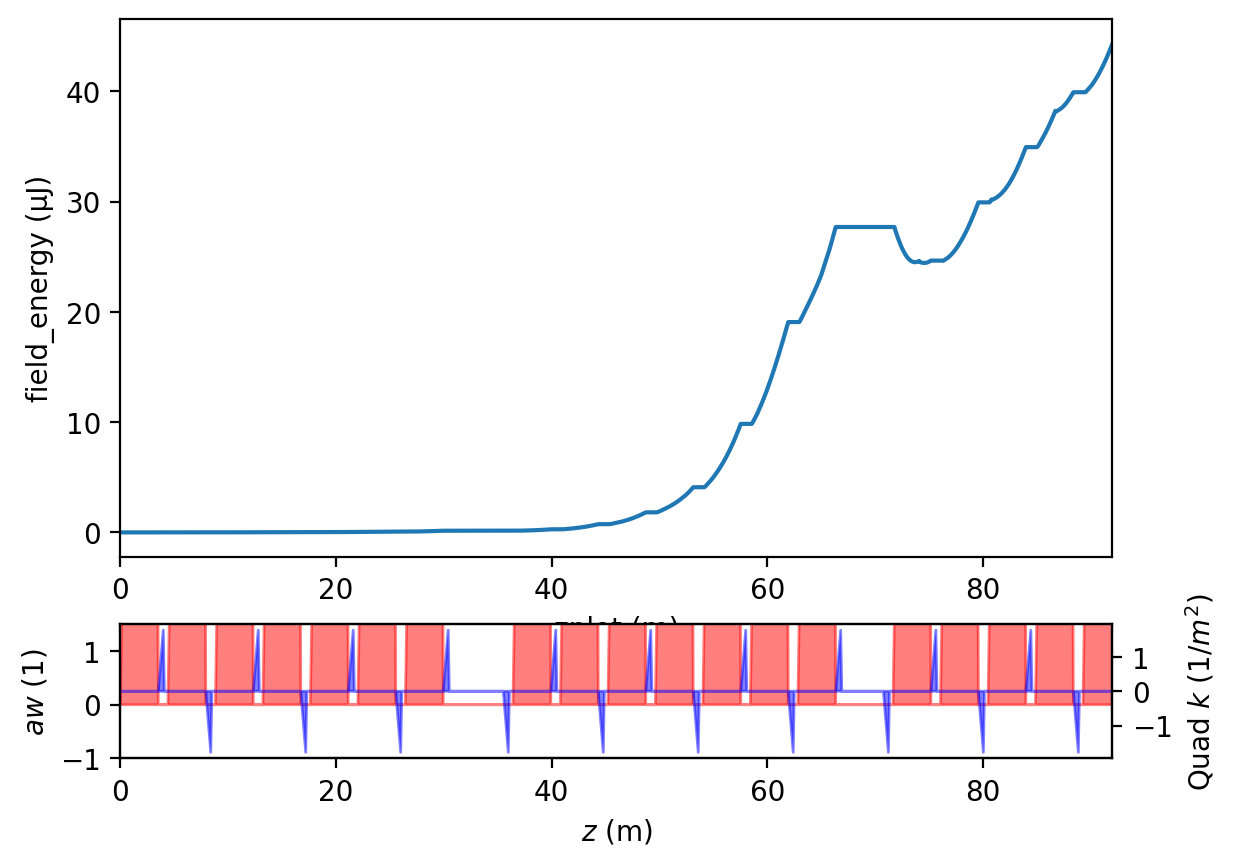

In [47]:
G2.plot()

# Cleanup

In [48]:
import shutil
shutil.rmtree('temp')
os.remove(afile)

# Future work

In [49]:
from dataclasses import dataclass

@dataclass
class Setup:
    rootname: str = None
    lattice: str = None
    beamline: str = None
    gamma0: float = 11350.3
    lambda0: float = 1e-10
    delz: float = 0.015
    seed: int = 123456789
    npart: int = 8192
    nbins: int = 4
    one4one: bool = False
    shotnoise: bool = True
    beam_global_stat: bool = False
    field_global_stat: bool = False
    exclude_spatial_output: bool = False
    exclude_fft_output: bool = False
    exclude_intensity_output: bool = False
    exclude_energy_output: bool = False
    exclude_aux_output: bool = False
    exclude_current_output: bool = True

In [50]:
dat = {
    'type':'setup',
   'rootname': 'LCLS2_HXR_9keV',
   'lattice': 'data/basic4/hxr.lat',
   'beamline': 'HXR',
   'lambda0': 1.3789244869952112e-10,
   'gamma0': 19174.0776,
   'delz': 0.026,
   'seed': 84672,
   'npart': 1024}

lookup = {'setup':Setup}

def make(dat):
    type = dat.pop('type')
    return lookup[type](**dat)
s = make(dat)
s

Setup(rootname='LCLS2_HXR_9keV', lattice='data/basic4/hxr.lat', beamline='HXR', gamma0=19174.0776, lambda0=1.3789244869952112e-10, delz=0.026, seed=84672, npart=1024, nbins=4, one4one=False, shotnoise=True, beam_global_stat=False, field_global_stat=False, exclude_spatial_output=False, exclude_fft_output=False, exclude_intensity_output=False, exclude_energy_output=False, exclude_aux_output=False, exclude_current_output=True)

In [51]:
s0 = Setup()

In [52]:
# These are the keys that are different from default:
from dataclasses import asdict
d2 = asdict(s0)
for k in list(d2):
    if getattr(s, k) == d2[k]:
        d2.pop(k)
list(d2)

['rootname',
 'lattice',
 'beamline',
 'gamma0',
 'lambda0',
 'delz',
 'seed',
 'npart']